In [2]:
import torch
from torchvision import models
from collections import namedtuple


class TransformerNet(torch.nn.Module):
    """See http://tinyurl.com/uwz9rwq"""

    def __init__(self):
        super().__init__()
        # Initial convolution layers
        self.conv1 = ConvLayer(3, 32, kernel_size=9, stride=1)
        self.in1 = torch.nn.InstanceNorm2d(32, affine=True)
        self.conv2 = ConvLayer(32, 64, kernel_size=3, stride=2)
        self.in2 = torch.nn.InstanceNorm2d(64, affine=True)
        self.conv3 = ConvLayer(64, 128, kernel_size=3, stride=2)
        self.in3 = torch.nn.InstanceNorm2d(128, affine=True)
        # Residual layers
        self.res1 = ResidualBlock(128)
        self.res2 = ResidualBlock(128)
        self.res3 = ResidualBlock(128)
        self.res4 = ResidualBlock(128)
        self.res5 = ResidualBlock(128)
        # Upsampling Layers
        self.deconv1 = UpsampleConvLayer(128, 64, kernel_size=3, stride=1, upsample=2)
        self.deconv2 = UpsampleConvLayer(64, 32, kernel_size=3, stride=1, upsample=2)
        self.in4 = torch.nn.InstanceNorm2d(64, affine=True)
        self.in5 = torch.nn.InstanceNorm2d(32, affine=True)
        self.deconv3 = ConvLayer(32, 3, kernel_size=9, stride=1)
        # Non-linearities
        self.relu = torch.nn.ReLU()

    def forward(self, X):
        y = self.relu(self.in1(self.conv1(X)))
        y = self.relu(self.in2(self.conv2(y)))
        y = self.relu(self.in3(self.conv3(y)))
        y = self.res1(y)
        y = self.res2(y)
        y = self.res3(y)
        y = self.res4(y)
        y = self.res5(y)
        y = self.relu(self.in4(self.deconv1(y)))
        y = self.relu(self.in5(self.deconv2(y)))
        y = self.deconv3(y)
        return y


class ConvLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super().__init__()
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out


class ResidualBlock(torch.nn.Module):
    """See https://arxiv.org/abs/1512.03385"""

    def __init__(self, channels):
        super().__init__()
        self.conv1 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in1 = torch.nn.InstanceNorm2d(channels, affine=True)
        self.conv2 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in2 = torch.nn.InstanceNorm2d(channels, affine=True)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.relu(self.in1(self.conv1(x)))
        out = self.in2(self.conv2(out))
        out = out + residual
        return out


class UpsampleConvLayer(torch.nn.Module):
    """See http://distill.pub/2016/deconv-checkerboard/"""

    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
        super(UpsampleConvLayer, self).__init__()
        self.upsample = upsample
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        x_in = x
        if self.upsample:
            x_in = torch.nn.functional.interpolate(x_in, mode="nearest", scale_factor=self.upsample)
        out = self.reflection_pad(x_in)
        out = self.conv2d(out)
        return out


class VGG16(torch.nn.Module):
    def __init__(self, requires_grad=False):
        super(VGG16, self).__init__()
        vgg_pretrained_features = models.vgg16(pretrained=True).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        for x in range(4):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(4, 9):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(9, 16):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(16, 23):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        h = self.slice1(X)
        h_relu1_2 = h
        h = self.slice2(h)
        h_relu2_2 = h
        h = self.slice3(h)
        h_relu3_3 = h
        h = self.slice4(h)
        h_relu4_3 = h
        vgg_outputs = namedtuple("VggOutputs", ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3'])
        out = vgg_outputs(h_relu1_2, h_relu2_2, h_relu3_3, h_relu4_3)
        return out

In [ ]:
import argparse
import math
import os
import sys
import time
import re
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms
from tqdm import tqdm_notebook as tqdm
from PIL import Image
from urllib.request import urlopen

style_image = "https://raw.githubusercontent.com/pytorch/examples/master/fast_neural_style/images/style-images/candy.jpg"
args = argparse.Namespace(**{"epochs": 2, "batch_size": 4, "dataset": "/home/centos/data/coco2014", "style_image": style_image, "image_size": 256, "seed": 42, "content_weight": 1e5, "style_weight": 1e10, "lr": 1e-3, "log_interval": 50,})

np.random.seed(args.seed)
torch.manual_seed(args.seed)

def gram_matrix(y):
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (ch * h * w)
    return gram


def normalize_batch(batch):
    mean = batch.new_tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
    std = batch.new_tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
    batch = batch.div_(255.0)
    return (batch - mean) / std


# Load content images
content_transform = transforms.Compose([transforms.Resize(args.image_size), transforms.CenterCrop(args.image_size), transforms.ToTensor(), transforms.Lambda(lambda x: x.mul(255)),])
train_loader = torch.utils.data.DataLoader(datasets.ImageFolder(args.dataset, content_transform), batch_size=args.batch_size)

# Load style image and extract features
vgg = VGG16(requires_grad=False).cuda()
style_transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.mul(255)),])
style = style_transform(Image.open(urlopen(args.style_image))).repeat(args.batch_size, 1, 1, 1).cuda()
gram_style = [gram_matrix(y) for y in vgg(normalize_batch(style))]

# Build transformer network and loss network
transformer = TransformerNet().cuda()
optimizer = torch.optim.Adam(transformer.parameters(), args.lr)
mse_loss = torch.nn.MSELoss()

for epoch in range(args.epochs):
    transformer.train()
    agg_content_loss, agg_style_loss = 0.0, 0.0
    progress_bar = tqdm(train_loader, "Epoch {:03d}".format(epoch))

    for batch_id, (x, _) in enumerate(progress_bar):
        x = x.cuda()
        y = normalize_batch(transformer(x))
        x = normalize_batch(x)

        features_y, features_x = vgg(y), vgg(x)
        content_loss = args.content_weight * mse_loss(features_y.relu2_2, features_x.relu2_2)
        style_loss = args.style_weight * sum(mse_loss(gram_matrix(ft_y), gm_s[:len(x), :, :]) for ft_y, gm_s in zip(features_y, gram_style))
        total_loss = content_loss + style_loss

        optimizer.zero_grad()
        total_loss.backward()
        grad_norm = math.sqrt(sum(p.grad.data.norm() ** 2 for p in transformer.parameters() if p.grad is not None))
        optimizer.step()

        agg_content_loss += content_loss.item()
        agg_style_loss += style_loss.item()
        progress_bar.set_postfix_str("loss {:,.4f}, content {:,.4f}, content {:,.4f}, grad_norm {:,.4f}".format((agg_content_loss + agg_style_loss) / (batch_id + 1), agg_content_loss / (batch_id + 1), agg_style_loss / (batch_id + 1), grad_norm))

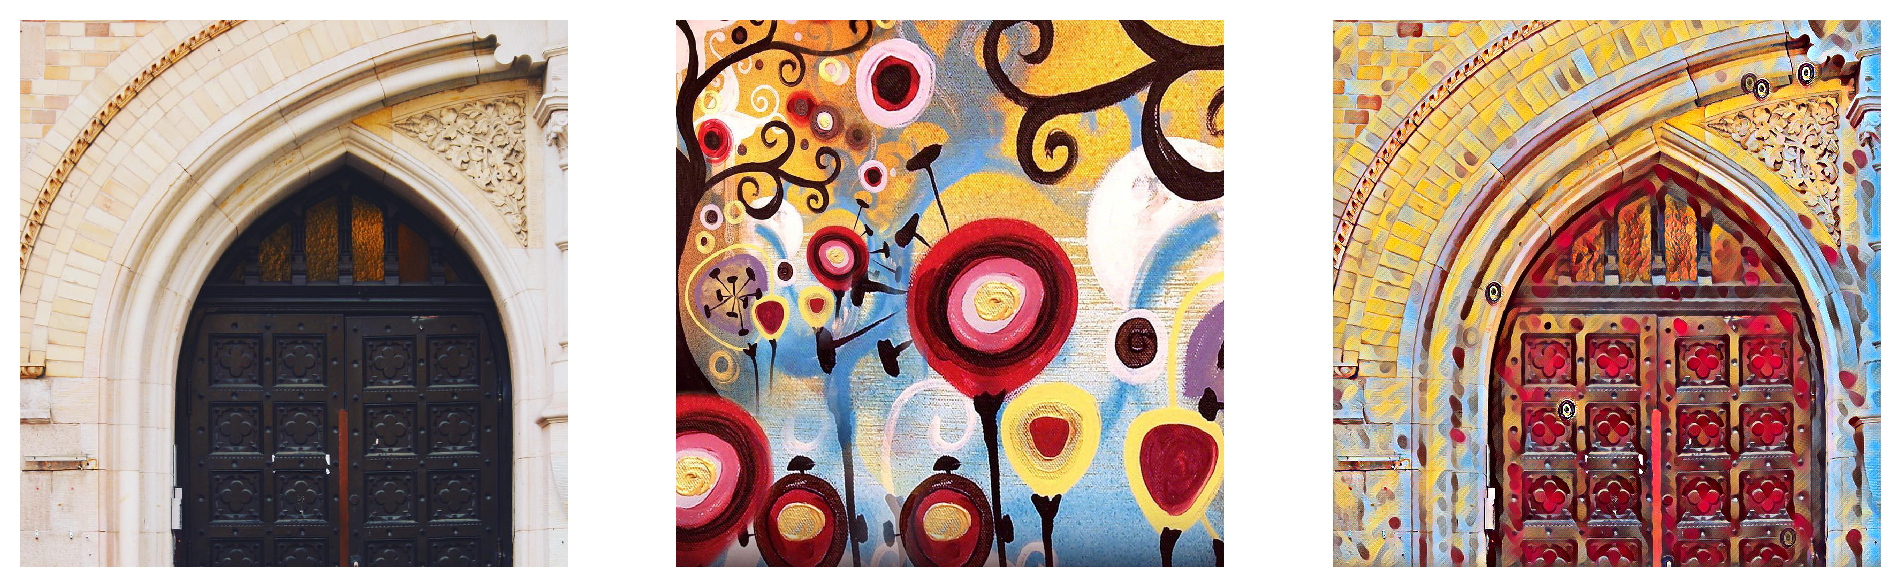

In [24]:
# Download pretrained model from https://github.com/pytorch/examples/tree/master/fast_neural_style
!mkdir /tmp/neural-style-transfer && wget -q https://www.dropbox.com/s/lrvwfehqdcxoza8/saved_models.zip?dl=0 -O /tmp/neural-style-transfer/models.zip
!unzip -qq /tmp/neural-style-transfer/models.zip -d /tmp/neural-style-transfer

# Load pretrained network into PyTorch
state_dict = torch.load('/tmp/neural-style-transfer/saved_models/candy.pth')
for k in list(state_dict.keys()):
    if re.search(r'in\d+\.running_(mean|var)$', k):
        del state_dict[k]
transformer.load_state_dict(state_dict)
transformer = transformer.cuda()

# Perform style transfer
with torch.no_grad():
    content_image = Image.open(urlopen("https://raw.githubusercontent.com/pytorch/examples/master/fast_neural_style/images/content-images/amber.jpg"))
    output = transformer(style_transform(content_image).unsqueeze(0).cuda()).cpu()
    
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(12, 4))
ax0.imshow(content_image)
ax0.axis("off")
ax1.imshow(Image.open(urlopen("https://raw.githubusercontent.com/pytorch/examples/master/fast_neural_style/images/style-images/candy.jpg")))
ax1.axis("off")
ax2.imshow(output[0].clamp(0, 255).numpy().transpose(1, 2, 0).astype("uint8"))
ax2.axis("off");

In [2]:
from IPython.core.display import HTML
HTML(open('../css/custom.css', 'r').read())